In [1]:
using Lale

In [2]:
using Random
using Statistics
using Test
using DataFrames: DataFrame, nrow
using AutoMLPipeline: Utils

In [3]:
iris = getiris();
trx,tstx = holdout(nrow(iris),0.30)
training = iris[trx,:]
testing = iris[tstx,:];

## AutoML for classifier pipeline

This example uses Lale for combined algorithm selection and hyperparameter tuning
on a classifier pipeline.

In [4]:
clf_tr_X = training[:,1:4] |> DataFrame
clf_tr_y = training[:,5]   |> Vector
clf_tst_X = testing[:,1:4] |> DataFrame
clf_tst_y = testing[:,5] |> Vector;

In [5]:
PCA = laleoperator("PCA")
RobustScaler = laleoperator("RobustScaler")
ConcatFeatures = laleoperator("ConcatFeatures", "lale")
LogisticRegression = laleoperator("LogisticRegression")
RandomForestClassifier = laleoperator("RandomForestClassifier");

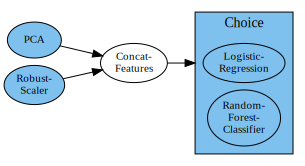

In [6]:
clf_planned = (PCA & RobustScaler) >> ConcatFeatures >> (LogisticRegression | RandomForestClassifier)
visualize(clf_planned)

100%|███████| 10/10 [00:08<00:00,  1.20trial/s, best loss: -0.9619047619047619]

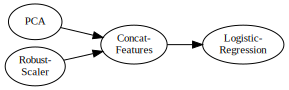

In [7]:
clf_hopt = LalePipeOptimizer(clf_planned, max_evals=10, cv=3)
clf_trained = fit(clf_hopt, clf_tr_X, clf_tr_y)
visualize(clf_trained)

In [8]:
clf_pred = predict(clf_trained, clf_tst_X)
clf_accu = score(:accuracy, clf_pred, clf_tst_y)

84.44444444444444

## AutoML for regressor pipeline

This example uses Lale for combined algorithm selection and hyperparameter tuning
on a regressor pipeline.

In [9]:
reg_tr_X = training[:,1:3] |> DataFrame
reg_tr_y = training[:,4]   |> Vector
reg_tst_X = testing[:,1:3] |> DataFrame
reg_tst_y = testing[:,4]   |> Vector;

In [10]:
PCA = laleoperator("PCA")
NoOp = laleoperator("NoOp", "lale")
LinearRegression = laleoperator("LinearRegression")
RandomForestRegressor = laleoperator("RandomForestRegressor");

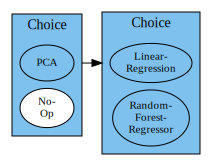

In [11]:
reg_planned = (PCA | NoOp) >> (LinearRegression | RandomForestRegressor);
visualize(reg_planned)


100%|███████| 10/10 [00:05<00:00,  1.68trial/s, best loss: -0.9343092607074653]

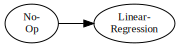

In [12]:
reg_hopt = LalePipeOptimizer(reg_planned, max_evals=10, cv=3)
reg_trained = fit(reg_hopt, reg_tr_X, reg_tr_y);
visualize(reg_trained)

In [13]:
reg_pred = predict(reg_trained, reg_tst_X)
reg_rmse = score(:rmse, reg_pred, reg_tst_y)

0.19349151914031384

## Other stuff

In [14]:
PCA |> typeof |> supertypes

(LaleOp, Lale.LaleAbsTypes.LaleOperator, Learner, Computer, Machine, Any)

In [15]:
RandomForestRegressor |> typeof |> supertypes

(LaleOp, Lale.LaleAbsTypes.LaleOperator, Learner, Computer, Machine, Any)

In [16]:
reg_hopt |> typeof |> supertypes

(LalePipeOptimizer, Lale.LaleAbsTypes.LaleOperator, Learner, Computer, Machine, Any)

In [17]:
# regression using AMLP pipeline
amlpipe = @pipeline  (PCA + NoOp) |> (RandomForestRegressor * LinearRegression)
crossvalidate(amlpipe, reg_tr_X, reg_tr_y, "mean_squared_error")
amlpred = fit!(amlpipe, reg_tr_X, reg_tr_y)
amlpred = transform!(amlpipe, reg_tst_X)
amlprmse = score(:rmse, amlpred, reg_tst_y)

fold: 1, 0.008663723139455801
fold: 2, 0.04169607247474744
fold: 3, 0.010784586388888795
fold: 4, 0.028424020583333244
fold: 5, 0.0611874869574832
fold: 6, 0.025909086969696894
fold: 7, 0.04469425686714079
fold: 8, 0.042188907331632663
fold: 9, 0.02886062899999997
fold: 10, 0.051183189494949904
errors: 0


0.1702649193211823

In [18]:
amlpipe |> typeof |> supertypes

(Pipeline, Workflow, Machine, Any)

In [19]:
# classification using AMLP pipeline
amlpipe = @pipeline  (PCA + RobustScaler) |> RandomForestClassifier
crossvalidate(amlpipe, clf_tr_X, clf_tr_y, "accuracy_score")
fit!(amlpipe, clf_tr_X, clf_tr_y)
amlpred = transform!(amlpipe,clf_tst_X)
amlpacc = score(:accuracy, amlpred, clf_tst_y)

fold: 1, 0.9
fold: 2, 1.0
fold: 3, 1.0
fold: 4, 0.9
fold: 5, 0.9
fold: 6, 1.0
fold: 7, 1.0
fold: 8, 1.0
fold: 9, 0.9
fold: 10, 1.0
errors: 0


95.55555555555556

In [20]:
# amlp ops
ohe  = OneHotEncoder()
catf = CatFeatureSelector()
numf = NumFeatureSelector();
#TODO: use Lale OneHotEncoder and Lale Project operators

In [21]:
plr = @pipeline (catf |> ohe) + (numf |> RobustScaler |> PCA) |> RandomForestRegressor;
crossvalidate(plr, reg_tr_X, reg_tr_y, "mean_absolute_error", 10, false) 

(mean = 0.16198594155844148, std = 0.03070046638325053, folds = 10, errors = 0)

In [22]:
plc = @pipeline (catf |> ohe) + (numf |> RobustScaler |> PCA) |> RandomForestClassifier;
crossvalidate(plc, clf_tr_X, clf_tr_y,"accuracy_score",10,false) 

(mean = 0.9354545454545453, std = 0.0866104924963963, folds = 10, errors = 0)